## Naive Bayes

           Company Name       Location  \
0  disability solutions   glendale, ca   
1  disability solutions   glendale, ca   
2    belmont university  nashville, tn   
3    belmont university  nashville, tn   
4   beck's hybrids\n4.6    atlanta, in   

                                       Job Title    job_category  python_yn  \
0                          advanced data analyst    Data Analyst        0.0   
1                          advanced data analyst    Data Analyst        0.0   
2  advancement services - temporary data analyst    Data Analyst        0.0   
3  advancement services – temporary data analyst    Data Analyst        0.0   
4                              ag data scientist  Data Scientist        0.0   

   R_yn  spark  aws  excel  avg_salary  
0   0.0    0.0  0.0    1.0    117500.0  
1   0.0    0.0  0.0    1.0    117500.0  
2   0.0    0.0  0.0    1.0    117500.0  
3   0.0    0.0  0.0    1.0    117500.0  
4   0.0    0.0  0.0    0.0    167440.0  
Training Data Sample:
    

c:\Users\shiva\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
c:\Users\shiva\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
c:\Users\shiva\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
c:\Users\shiva\anaconda3\Lib\site-packages\sklearn\preprocessing\_discret

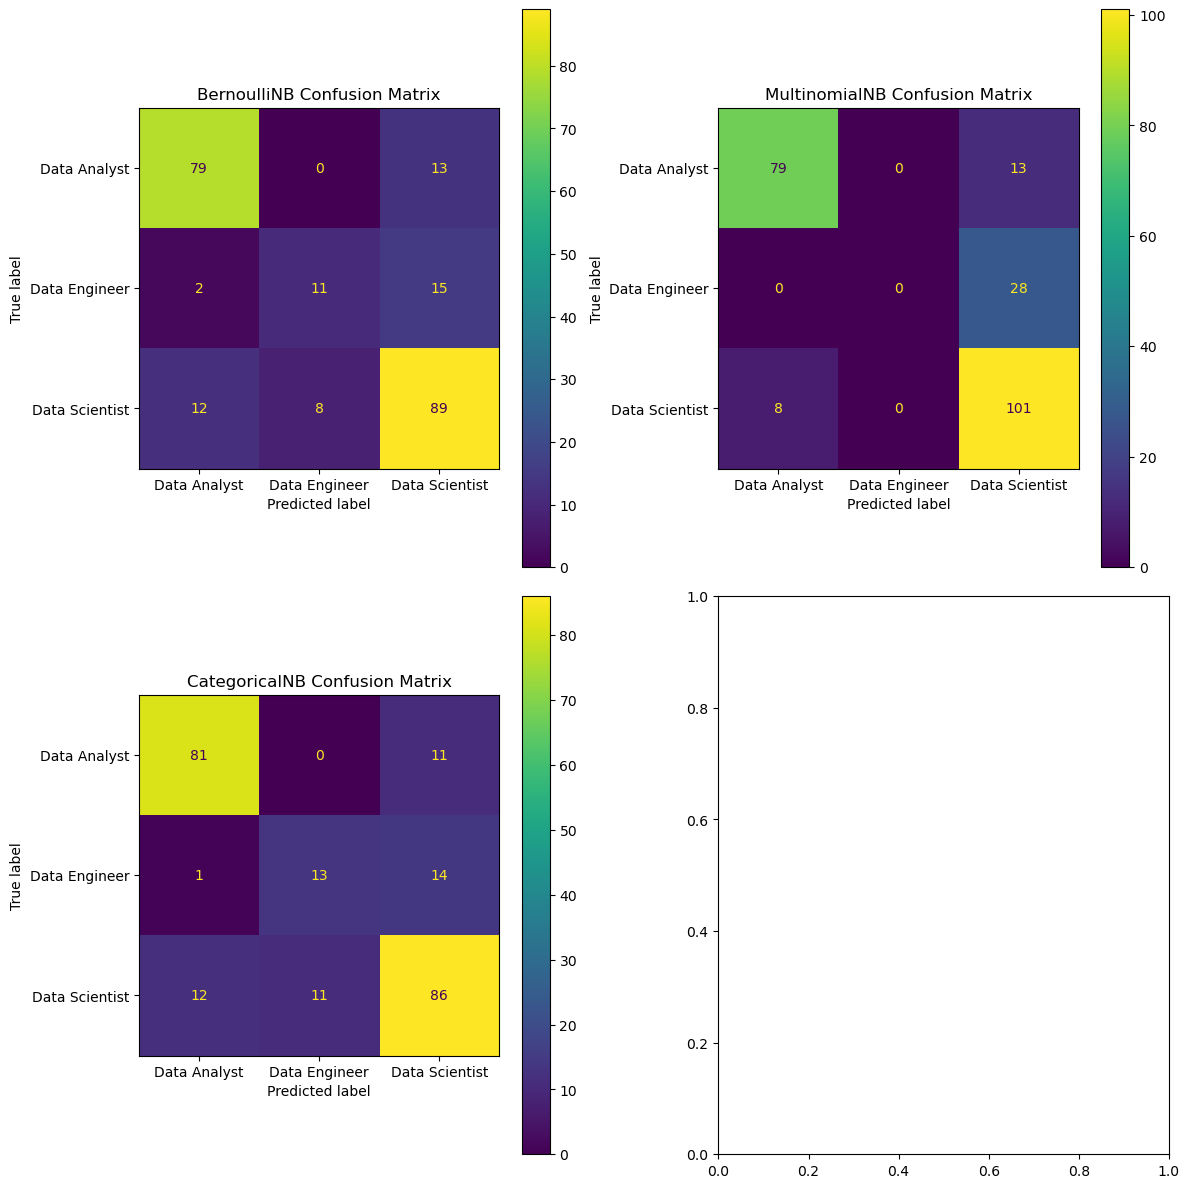

BernoulliNB CV Accuracy: 0.7686
BernoulliNB Test Accuracy: 0.7817
MultinomialNB Best Parameters: {'discretizer__n_bins': 5, 'discretizer__strategy': 'kmeans'}
MultinomialNB Best CV Accuracy: 0.8286
MultinomialNB Test Accuracy: 0.7860
CategoricalNB Best Parameters: {}
CategoricalNB Best CV Accuracy: 0.7959
CategoricalNB Test Accuracy: 0.7860


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, KBinsDiscretizer, OrdinalEncoder
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, CategoricalNB
from sklearn.pipeline import Pipeline

# Load data
df = pd.read_csv('datasets/final_cleaned_data.csv')
print(df.head())
# Encode target variable
le = LabelEncoder()
y = le.fit_transform(df['job_category'])

# Select features
features = ['python_yn', 'R_yn', 'spark', 'aws', 'excel', 'avg_salary']
X = df[features]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print train and test data samples
print("Training Data Sample:")
print(X_train.head())
print(y_train[:5])  # Prints the first 5 target values from the training set

print("Testing Data Sample:")
print(X_test.head())
print(y_test[:5])  # Prints the first 5 target values from the testing set

# Set up a subplot grid for plotting confusion matrices
fig, ax = plt.subplots(2, 2, figsize=(12, 12))  # Adjust size as needed

# Model 1: BernoulliNB (uses binary features only)
bnb = BernoulliNB(alpha=1.0)  # Default alpha=1.0, adjust as necessary
scores = cross_val_score(bnb, X_train[['python_yn', 'R_yn', 'spark', 'aws', 'excel']], y_train, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='accuracy')
bnb.fit(X_train[['python_yn', 'R_yn', 'spark', 'aws', 'excel']], y_train)
y_pred_bnb = bnb.predict(X_test[['python_yn', 'R_yn', 'spark', 'aws', 'excel']])
accuracy_bnb = accuracy_score(y_test, y_pred_bnb)
precision_bnb = precision_score(y_test, y_pred_bnb, average='weighted')
recall_bnb = recall_score(y_test, y_pred_bnb, average='weighted')
f1_bnb = f1_score(y_test, y_pred_bnb, average='weighted')
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_bnb), display_labels=le.classes_)
disp.plot(ax=ax[0, 0])
ax[0, 0].set_title('BernoulliNB Confusion Matrix')

# Model 2: MultinomialNB (discretize avg_salary into bins)
pipeline_mnb = Pipeline([
    ('discretizer', KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')),
    ('classifier', MultinomialNB())
])
param_grid_mnb = {
    'discretizer__n_bins': [3, 5, 10],
    'discretizer__strategy': ['uniform', 'quantile', 'kmeans']
}
grid_mnb = GridSearchCV(pipeline_mnb, param_grid_mnb, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='accuracy')
grid_mnb.fit(X_train, y_train)
y_pred_mnb = grid_mnb.predict(X_test)
accuracy_mnb = accuracy_score(y_test, y_pred_mnb)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_mnb), display_labels=le.classes_)
disp.plot(ax=ax[0, 1])
ax[0, 1].set_title('MultinomialNB Confusion Matrix')

# Model 3: CategoricalNB (all features as categorical)
encoder = OrdinalEncoder()
X_encoded = encoder.fit_transform(X)
X_train_enc, X_test_enc, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
pipeline_cnb = Pipeline([
    ('classifier', CategoricalNB())
])
grid_cnb = GridSearchCV(pipeline_cnb, {}, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='accuracy')
grid_cnb.fit(X_train_enc, y_train)
y_pred_cnb = grid_cnb.predict(X_test_enc)
accuracy_cnb = accuracy_score(y_test, y_pred_cnb)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_cnb), display_labels=le.classes_)
disp.plot(ax=ax[1, 0])
ax[1, 0].set_title('CategoricalNB Confusion Matrix')

# Display all confusion matrices
plt.tight_layout()
plt.show()

# Print accuracy and other metrics
print(f"BernoulliNB CV Accuracy: {np.mean(scores):.4f}")
print(f"BernoulliNB Test Accuracy: {accuracy_bnb:.4f}")
print(f"MultinomialNB Best Parameters: {grid_mnb.best_params_}")
print(f"MultinomialNB Best CV Accuracy: {grid_mnb.best_score_:.4f}")
print(f"MultinomialNB Test Accuracy: {accuracy_mnb:.4f}")
print(f"CategoricalNB Best Parameters: {grid_cnb.best_params_}")
print(f"CategoricalNB Best CV Accuracy: {grid_cnb.best_score_:.4f}")
print(f"CategoricalNB Test Accuracy: {accuracy_cnb:.4f}")


## Decision Trees

Accuracy of Decision Tree 1 (Depth=3, MinSamplesSplit=2, Criterion=gini): 0.81


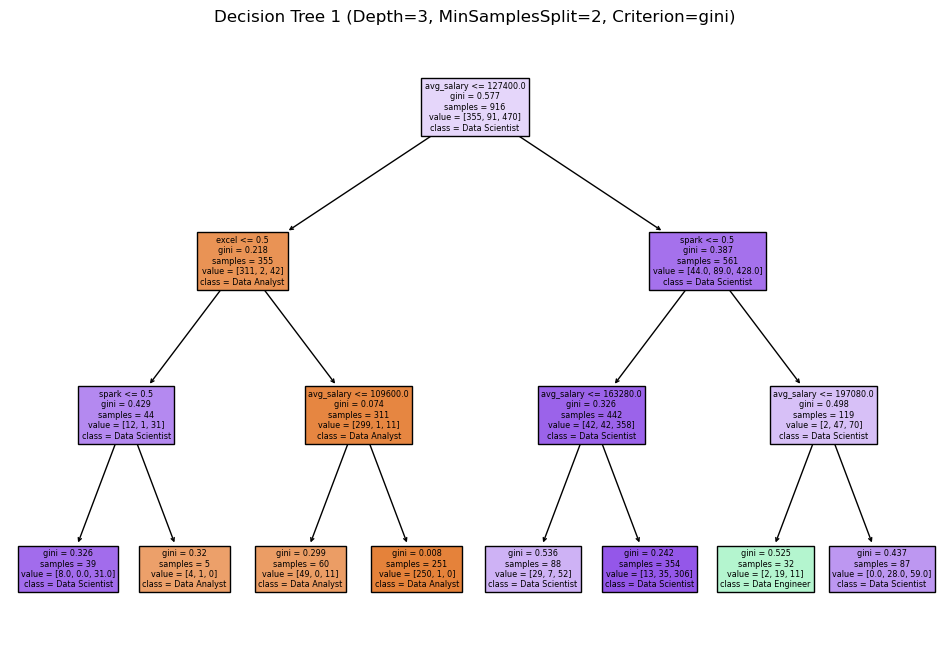

<Figure size 800x800 with 0 Axes>

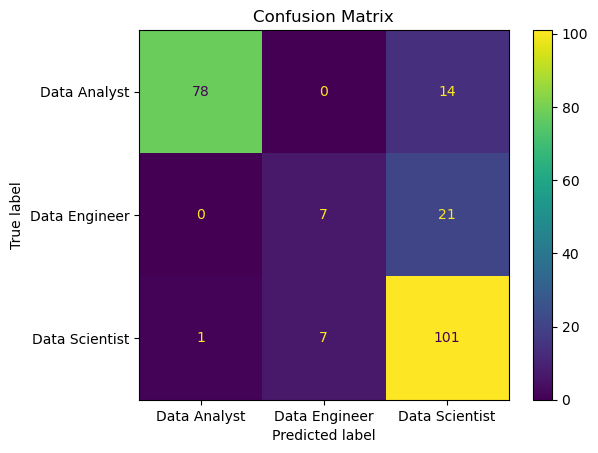

Accuracy of Decision Tree 2 (Depth=4, MinSamplesSplit=4, Criterion=gini): 0.79


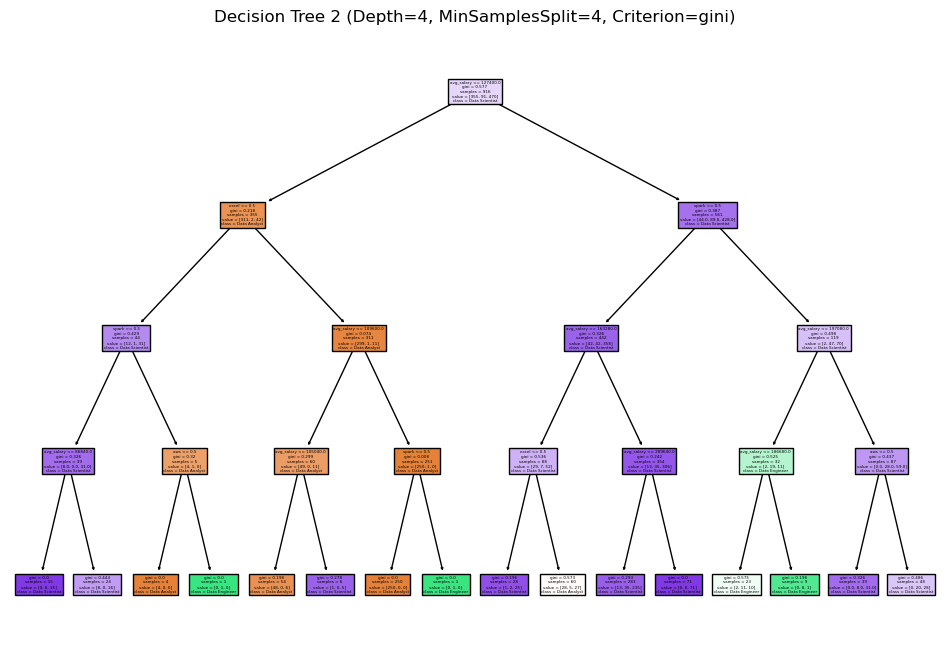

<Figure size 800x800 with 0 Axes>

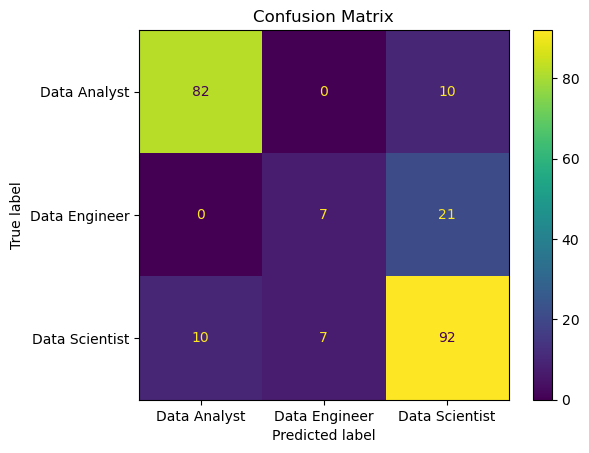

Accuracy of Decision Tree 3 (Depth=5, MinSamplesSplit=3, Criterion=entropy): 0.81


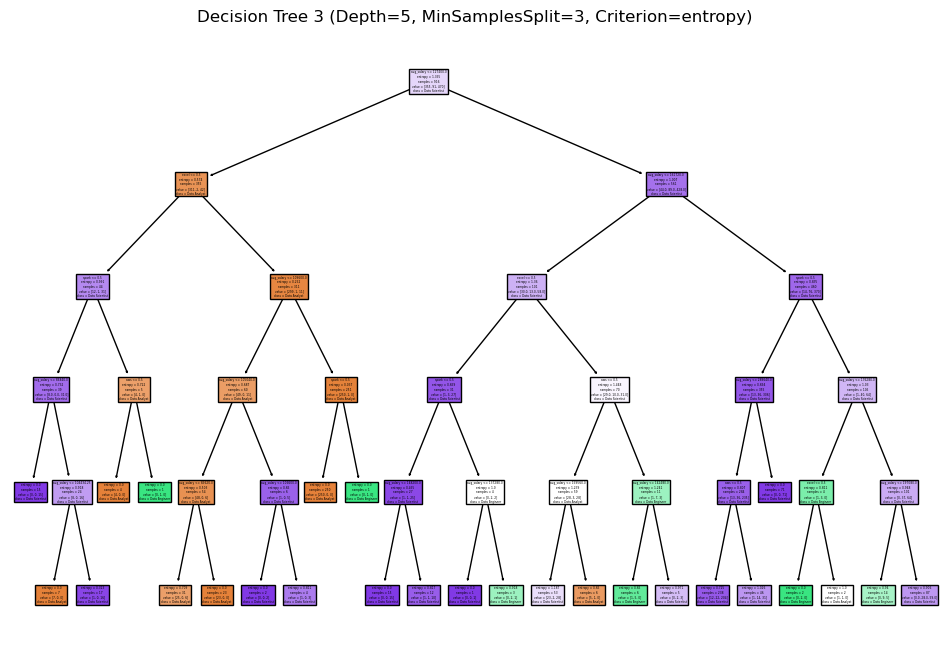

<Figure size 800x800 with 0 Axes>

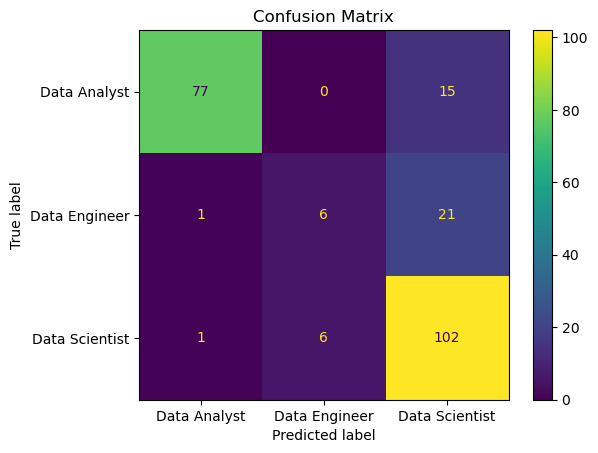

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd

# Load data
df = pd.read_csv('datasets/final_cleaned_data.csv')

# Encode target variable
le = LabelEncoder()
y = le.fit_transform(df['job_category'])

# Define feature sets to change the starting node
feature_sets = [
    ['avg_salary', 'python_yn', 'R_yn', 'spark', 'aws', 'excel'],  # Prioritize 'avg_salary'
    ['spark', 'aws', 'excel', 'python_yn', 'R_yn', 'avg_salary'],  # Prioritize 'spark'
    ['excel', 'aws', 'spark', 'R_yn', 'python_yn', 'avg_salary']   # Prioritize 'excel'
]

# Split data
X_train, X_test, y_train, y_test = train_test_split(df[features], y, test_size=0.2, random_state=42)

# Define different configurations for the Decision Tree
configurations = [
    {'max_depth': 3, 'min_samples_split': 2, 'criterion': 'gini'},
    {'max_depth': 4, 'min_samples_split': 4, 'criterion': 'gini'},
    {'max_depth': 5, 'min_samples_split': 3, 'criterion': 'entropy'}
]

# Generate and plot each tree with different configurations and feature sets
for i, (config, feature_set) in enumerate(zip(configurations, feature_sets)):
    X_train_selected = X_train[feature_set]
    X_test_selected = X_test[feature_set]
    
    dt = DecisionTreeClassifier(random_state=42, **config)
    dt.fit(X_train_selected, y_train)
    
    # Predict the labels on the test set
    y_pred = dt.predict(X_test_selected)
    
    # Calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy of Decision Tree {i+1} (Depth={config['max_depth']}, MinSamplesSplit={config['min_samples_split']}, Criterion={config['criterion']}): {accuracy:.2f}")
    
    # Plotting the decision tree
    plt.figure(figsize=(12, 8))
    plot_tree(dt, filled=True, feature_names=feature_set, class_names=np.unique(le.inverse_transform(y)).astype(str))
    plt.title(f"Decision Tree {i+1} (Depth={config['max_depth']}, MinSamplesSplit={config['min_samples_split']}, Criterion={config['criterion']})")
    plt.show()

    # Generate and display the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(le.inverse_transform(y)))
    plt.figure(figsize=(8, 8))
    disp.plot()
    plt.title('Confusion Matrix')
    plt.show()





## Logistic Regression

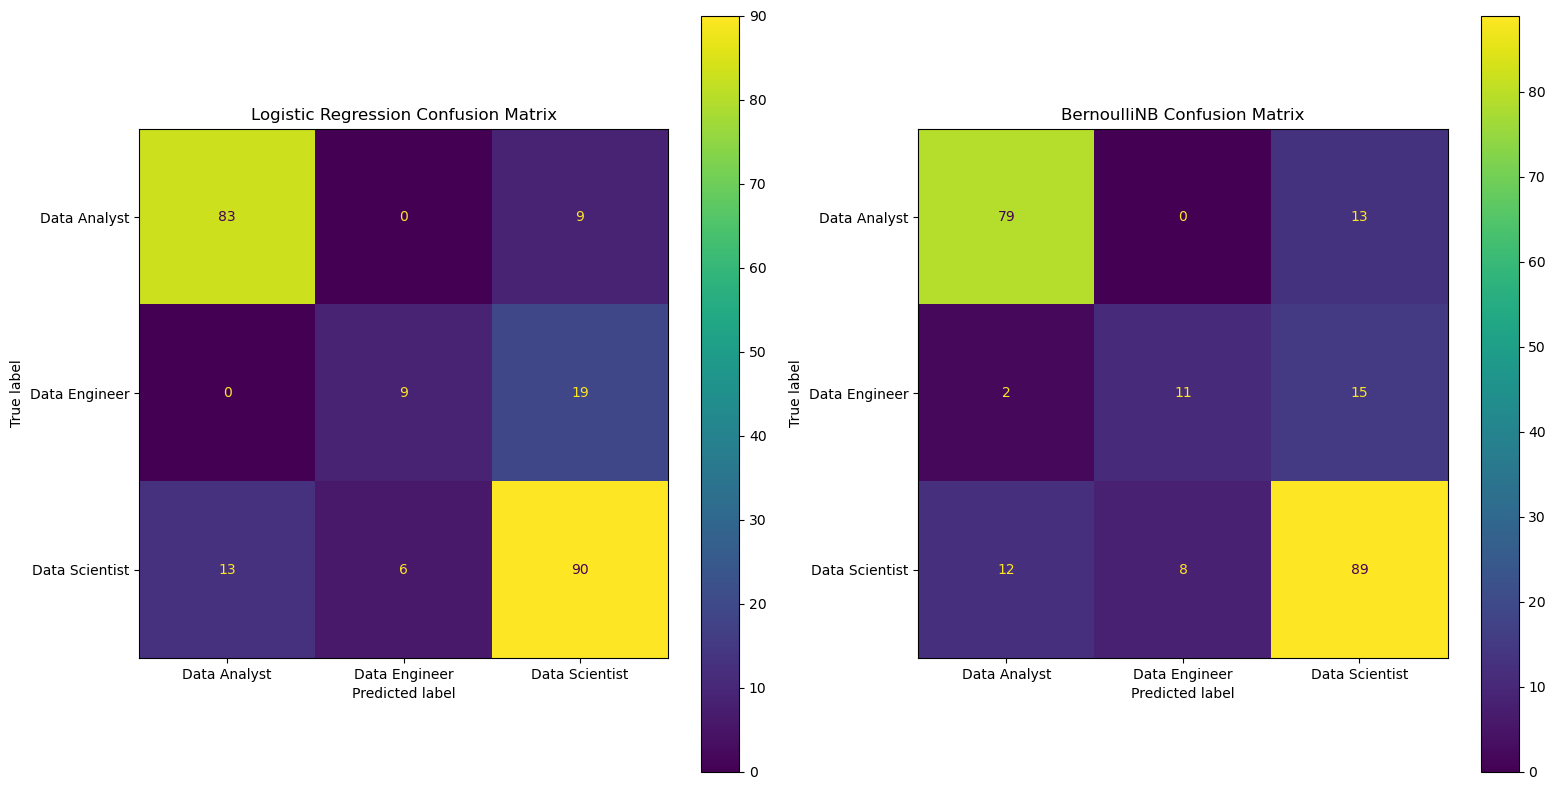

Logistic Regression Metrics:
Accuracy: 0.79, Precision: 0.78, Recall: 0.79, F1-Score: 0.78
BernoulliNB Metrics:
Accuracy: 0.78, Precision: 0.77, Recall: 0.78, F1-Score: 0.78


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Load data
df = pd.read_csv('datasets/final_cleaned_data.csv')

# Encode target variable
le = LabelEncoder()
df['job_category'] = le.fit_transform(df['job_category'])

# Select features
features = ['python_yn', 'R_yn', 'spark', 'aws', 'excel', 'avg_salary']
X = df[features]
y = df['job_category']

# Scale features for Logistic Regression
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Model 1: Logistic Regression
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr, average='weighted')
recall_lr = recall_score(y_test, y_pred_lr, average='weighted')
f1_lr = f1_score(y_test, y_pred_lr, average='weighted')

# Model 2: BernoulliNB (Using only binary features)
bnb = BernoulliNB()
X_train_binary = X_train[:, :5]  # Assuming the first five features are binary
X_test_binary = X_test[:, :5]
bnb.fit(X_train_binary, y_train)
y_pred_bnb = bnb.predict(X_test_binary)
accuracy_bnb = accuracy_score(y_test, y_pred_bnb)
precision_bnb = precision_score(y_test, y_pred_bnb, average='weighted')
recall_bnb = recall_score(y_test, y_pred_bnb, average='weighted')
f1_bnb = f1_score(y_test, y_pred_bnb, average='weighted')

# Set up subplot grid
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Plot confusion matrix for Logistic Regression
disp_lr = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_lr),
                                 display_labels=le.classes_)
disp_lr.plot(ax=ax[0])
ax[0].set_title('Logistic Regression Confusion Matrix')

# Plot confusion matrix for BernoulliNB
disp_bnb = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_bnb),
                                  display_labels=le.classes_)
disp_bnb.plot(ax=ax[1])
ax[1].set_title('BernoulliNB Confusion Matrix')

# Show plots
plt.tight_layout()
plt.show()

# Print accuracy and other metrics
print("Logistic Regression Metrics:")
print(f"Accuracy: {accuracy_lr:.2f}, Precision: {precision_lr:.2f}, Recall: {recall_lr:.2f}, F1-Score: {f1_lr:.2f}")
print("BernoulliNB Metrics:")
print(f"Accuracy: {accuracy_bnb:.2f}, Precision: {precision_bnb:.2f}, Recall: {recall_bnb:.2f}, F1-Score: {f1_bnb:.2f}")
